In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, math
import sklearn.mixture as mixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
# detect face helper
face_front = cv2.CascadeClassifier( './face_detection_classifier/haarcascade_profileface_cuda.xml')


In [3]:
class Image:
    def __init__(self, image_gray):
        self.image_gray = image_gray
        self.keypoints = []
        self.histogram = []

In [4]:
# takes input of the path to the training images, returns list of gray scaled images and name
def load_images(image_path):
    # get all train images name
    train_dataset = os.listdir(image_path)
    images_name = [img_name for img_name in train_dataset if img_name.endswith('.png')]
    images_name.sort()
    images = []
    # read all train images
    for image_name in images_name:
        img_gray = cv2.imread(image_path + image_name, cv2.IMREAD_GRAYSCALE)
        image = Image(img_gray)
        images.append(image)
    return images

In [5]:
class Person:
    def __init__(self, name, train_image_path, test_image_path):
        self.name = name
        self.train_image_path = train_image_path
        self.test_image_path = test_image_path
        # train_images takes a list of Image object
        self.train_images = load_images(train_image_path)
        self.test_images = load_images(test_image_path)
    def append_train_image(self, train_image):
        self.train_images.append(train_image)
    def append_test_image(self, test_image):
        self.test_images.append(test_image)

In [6]:
lily = Person("Lily", './dataset/LILY_TRAIN_1/', './dataset/LILY_TEST/')
mai = Person("Mai", './dataset/MAI_TRAIN_1/', './dataset/MAI_TEST/')
jacob = Person("Mai", './dataset/JACOB_TRAIN/', './dataset/JACOB_TEST/')

In [8]:
# takes an image as input, find the face on the image, and the keypoints in the face bounding box
# add all the keypoints to the image object
def find_keypoints_on_face(image):
    img = image.image_gray
    # check for face two times to ensure the output are all faces
#     face = face_front.detectMultiScale(img, scaleFactor=1.00154, minNeighbors=6)
#     if len(face) == 0 :
# #         face = face_front.detectMultiScale(img, scaleFactor=1.0015, minNeighbors=7)
# #         x, y, w, h = face[-1]
# #         face_extract = img[y-5:y+h+10, x-5:x+w+10]
# #         face_extract = cv2.resize(face_extract, size) 
# #         faces.append(face[-1])
# #         continue
#         print("no face found")
#         return 
#     x, y, w, h = face[0] # we know that there is only one face per training sample.
    x = 50
    y = 50
    w = 150
    h = 150
     # create a mask image filled with zeros, the size of original image
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    # draw your selected ROI on the mask image
    cv2.rectangle(mask, (x,y), (x+w,y+h), (255), thickness = -1)
    sift = cv2.xfeatures2d.SIFT_create()
    # provide mask to the detect method
    kp = sift.detect(img, mask)
    image.keypoints = kp
    

In [9]:
#takes list of images, compute hog features and output the list of features
def HoG(images, cell):
    cell_size = (cell, cell)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins
    features = []
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to multiple of the cell size
        # all arguments should be given in terms of number of pixels
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                          img.shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

        # Compute HoG features
        hog_feats = hog.compute(img)
        hog_feats = hog_feats.flatten()
        features.append(hog_feats)
    features=np.array(features)
    return features

In [10]:
def BOV_SIFT(image, cell, k):
    img = image.image_gray
    kp = image.keypoints
    if(len(kp)<40):
        return []
    patches = []
    for key in kp:
        x = int(key.pt[0] - 7);
        y = int(key.pt[1] - 7);
        roi = img[y:y+15, x:x+15]
        if(roi.shape[0] == 15 and roi.shape[1] == 15):
            patches.append(roi)
    patches = np.array(patches)
    
    descriptors = HoG(patches, cell)
    gmm = mixture.GaussianMixture(covariance_type='full', n_components=k)
    gmm.fit(descriptors)
#     clusters = gmm.predict(descriptors)
#     plt.bar(range(k), gmm.weights_)
#     plt.show()
    return gmm.weights_

In [ ]:
histograms = []
labels = []
for train_image in lily.train_images:
    if(len(train_image.histogram) > 0):
        histograms.append(train_image.histogram)
        labels.append(0)
        
for train_image in mai.train_images:
    if(len(train_image.histogram) > 0):
        histograms.append(train_image.histogram)
        labels.append(1)
print(labels)
print(len(histograms))

test_histograms = []
test_labels = []
for test_image in lily.test_images:
    if(len(test_image.histogram) > 0):
        test_histograms.append(test_image.histogram)
        test_labels.append(0)
        
for test_image in mai.test_images:
    if(len(test_image.histogram) > 0):
        test_histograms.append(test_image.histogram)
        test_labels.append(1)
        

print(test_labels)
print(len(test_histograms))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
model.fit(histograms, labels)

prediction=[]
for test in test_histograms:
    predicted= model.predict([test]) # 0:Overcast, 2:Mild
    print(predicted)
    prediction.append(predicted[0])
    
print(prediction)
print(test_labels)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_rate = accuracy_score(test_labels, prediction)
print(accuracy_rate)
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels, prediction)
plt.imshow(conf_matrix)

49
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
33
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
0.42424242424242425


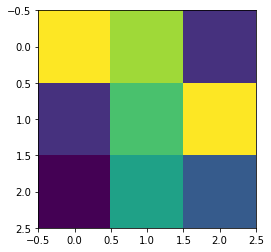

49
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
33
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[1, 2, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
0.42424242424242425


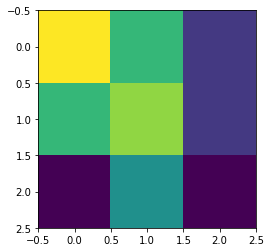

49
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
33
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[0, 2, 1, 2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
0.42424242424242425


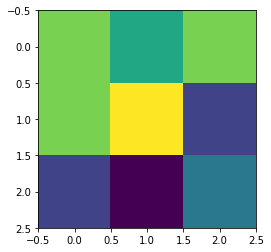

In [30]:
cell_sizes = [3,4,5]
members = [lily, mai, jacob]
k_clusters = [10, 18, 22, 25, 22]
k = k_clusters[2]
for cell in cell_sizes:
    train_histograms = []
    train_labels = []
    test_histograms = []
    test_labels = []
    # build vocabularies for each person's train and test images
    for index, person in enumerate(members):
        for train_image in person.train_images:
            find_keypoints_on_face(train_image)
            train_image.histogram = BOV_SIFT(train_image, cell, k)
            if(len(train_image.histogram) > 0):
                train_histograms.append(train_image.histogram)
                train_labels.append(index)
        for test_image in person.test_images:
            find_keypoints_on_face(test_image)
            test_image.histogram = BOV_SIFT(test_image, cell, k)
            if(len(test_image.histogram) > 0):
                test_histograms.append(test_image.histogram)
                test_labels.append(index)
            
    print(len(train_histograms))
    print(train_labels)
    print(len(test_histograms))
    print(test_labels)
    #knearest-neighbor classifier
    model = KNeighborsClassifier(n_neighbors=5)

    # Train the model using the training sets
    model.fit(train_histograms, train_labels)

    prediction=[]
    for test in test_histograms:
        predicted= model.predict([test]) # 0:Overcast, 2:Mild
        prediction.append(predicted[0])
        
    print(prediction)
    print(test_labels)
    accuracy_rate = accuracy_score(test_labels, prediction)
    print(accuracy_rate)
    conf_matrix = confusion_matrix(test_labels, prediction)
    plt.imshow(conf_matrix)
    plt.show()

In [31]:
from skimage import feature
def LBP(images, radius):
    P = 8 * radius
    R = radius
    features = []
    eps = 1e-7
    for img in images:
        lbp = feature.local_binary_pattern(img, P, R)
        (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, P + 3),range=(0, P + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        
        features.append(hist)
    features=np.array(features)
#     print(features.shape)
#     print(features[0])
    return features

In [32]:
def BOW_LBP(image, radius, k):
    img = image.image_gray
    kp = image.keypoints
    if(len(kp)<40):
        return []
    patches = []
    for key in kp:
        x = int(key.pt[0] - 7);
        y = int(key.pt[1] - 7);
        roi = img[y:y+15, x:x+15]
        if(roi.shape[0] == 15 and roi.shape[1] == 15):
            patches.append(roi)
    patches = np.array(patches)
    
    descriptors = LBP(patches, radius)
    gmm = mixture.GaussianMixture(covariance_type='full', n_components=k)
    gmm.fit(descriptors)
#     clusters = gmm.predict(descriptors)
#     plt.bar(range(k), gmm.weights_)
#     plt.show()
    return gmm.weights_

49
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
33
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[0, 1, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
0.48484848484848486


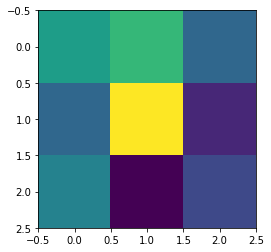

49
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
33
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[2, 1, 0, 0, 2, 2, 0, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
0.21212121212121213


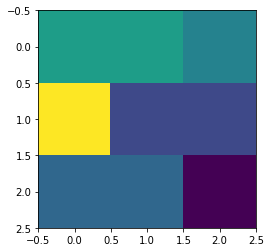

49
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
33
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
0.45454545454545453


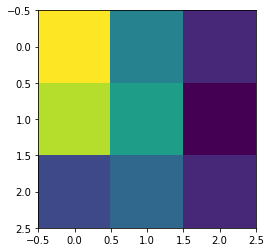

In [33]:
radius_list = [2,7,12]
for radius in radius_list:
    train_histograms = []
    train_labels = []
    test_histograms = []
    test_labels = []
    # build vocabularies for each person's train and test images
    for index, person in enumerate(members):
        for train_image in person.train_images:
            find_keypoints_on_face(train_image)
            train_image.histogram = BOW_LBP(train_image, radius, k)
            if(len(train_image.histogram) > 0):
                train_histograms.append(train_image.histogram)
                train_labels.append(index)
        for test_image in person.test_images:
            find_keypoints_on_face(test_image)
            test_image.histogram = BOW_LBP(test_image, radius, k)
            if(len(test_image.histogram) > 0):
                test_histograms.append(test_image.histogram)
                test_labels.append(index)
            
    print(len(train_histograms))
    print(train_labels)
    print(len(test_histograms))
    print(test_labels)
    #knearest-neighbor classifier
    model = KNeighborsClassifier(n_neighbors=2)

    # Train the model using the training sets
    model.fit(train_histograms, train_labels)

    prediction=[]
    for test in test_histograms:
        predicted= model.predict([test]) # 0:Overcast, 2:Mild
        prediction.append(predicted[0])
        
    print(prediction)
    print(test_labels)
    accuracy_rate = accuracy_score(test_labels, prediction)
    print(accuracy_rate)
    conf_matrix = confusion_matrix(test_labels, prediction)
    plt.imshow(conf_matrix)
    plt.show()

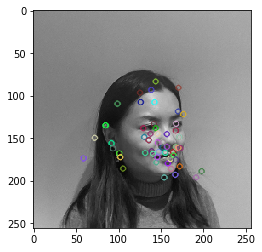

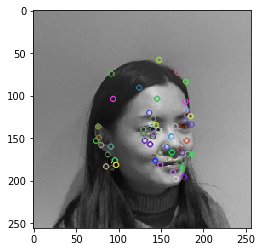

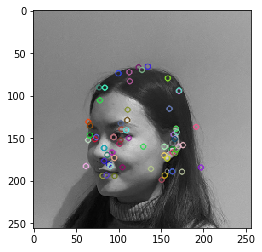

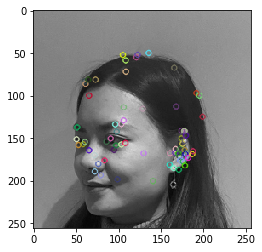

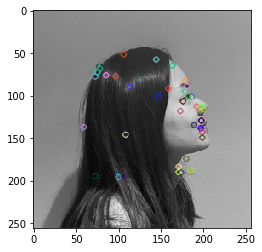

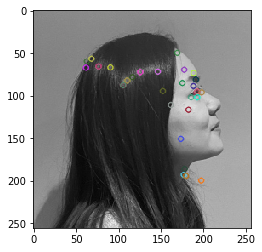

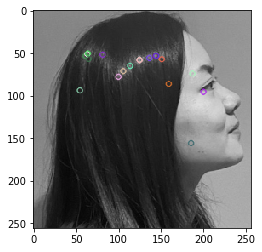

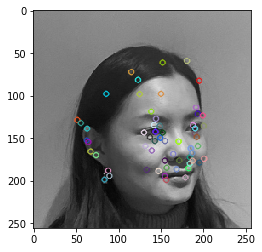

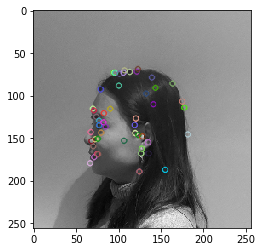

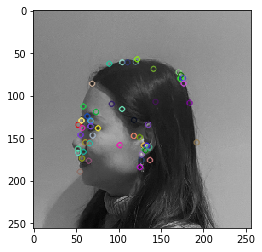

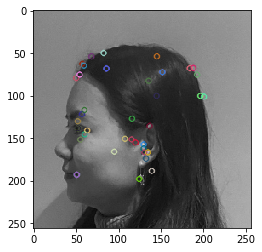

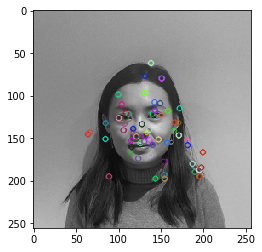

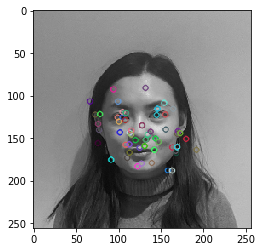

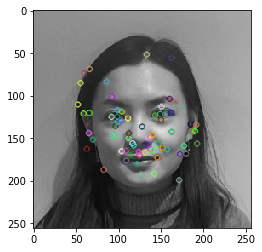

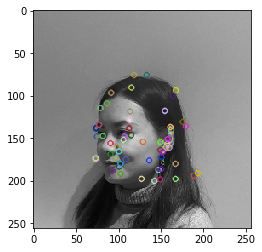

In [27]:
for train_image in lily.train_images:
    img_copy = train_image.image_gray.copy()
    img_keypoints=cv2.drawKeypoints(img_copy,train_image.keypoints,img_copy)
    plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
    plt.show()

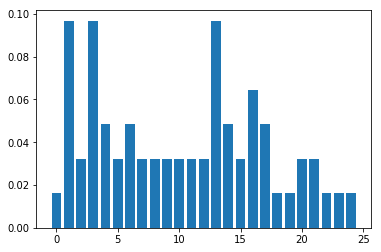

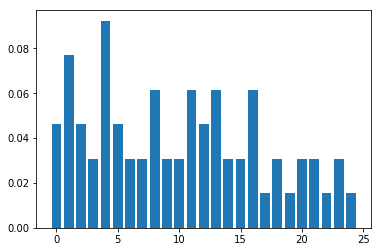

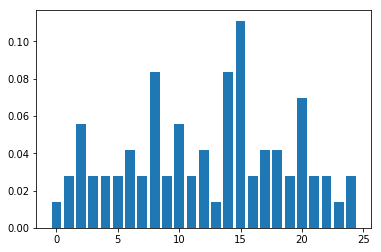

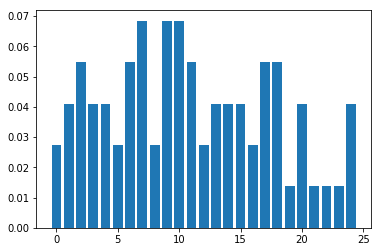

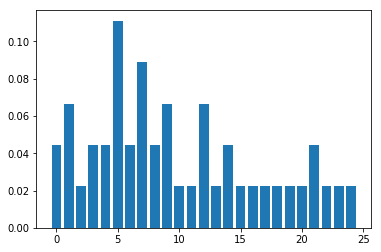

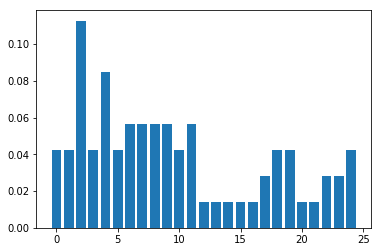

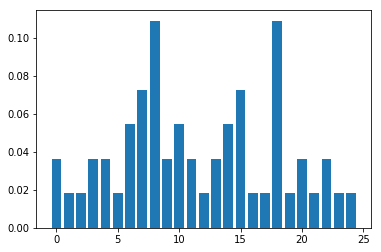

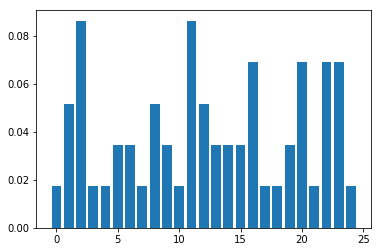

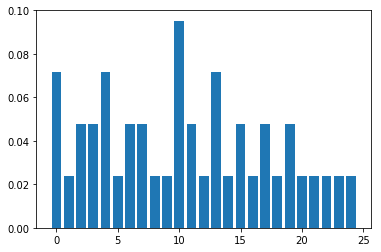

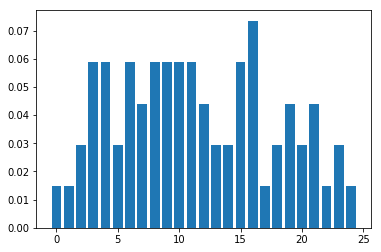

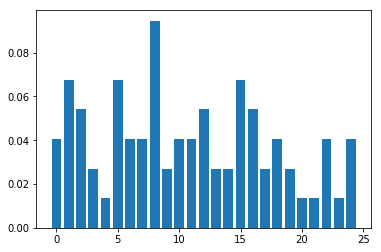

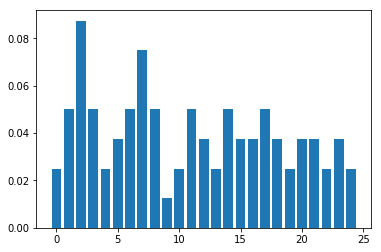

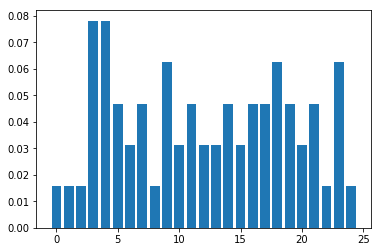

In [25]:
for train_image in lily.train_images:
    if(len(train_image.histogram) > 0):
        k = len(train_image.histogram)
        plt.bar(range(k), train_image.histogram)
        plt.show() 